In [1]:
%cd ..

c:\Users\justi\coding\Uni\MA


In [2]:
import glob
import pickle

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Plot a signal

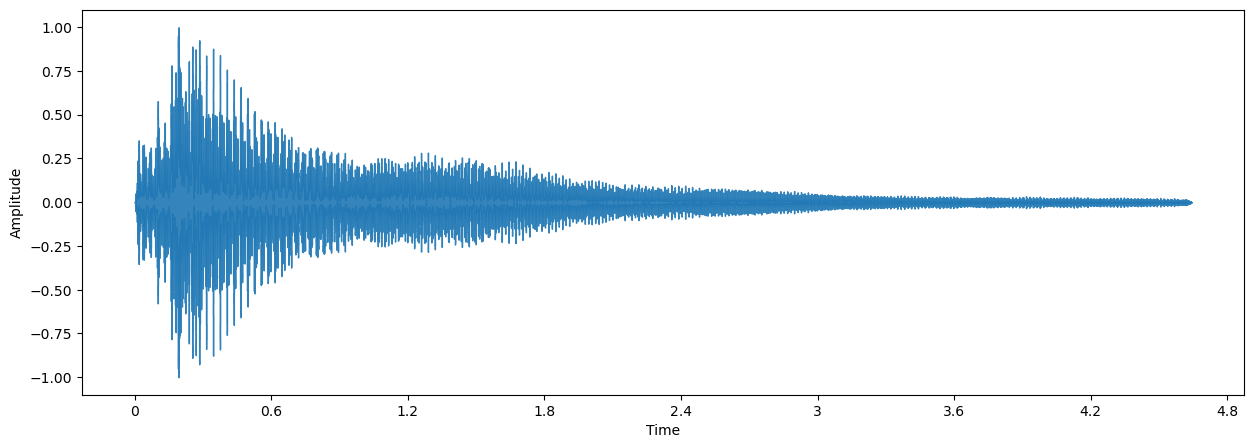

In [26]:
import librosa 
y, sr = librosa.load("./audio/GuitarStrum.wav")
plt.figure(figsize=(15, 5))
plt.ylabel("Amplitude")
librosa.display.waveshow(y=y, sr=sr, alpha=0.9)

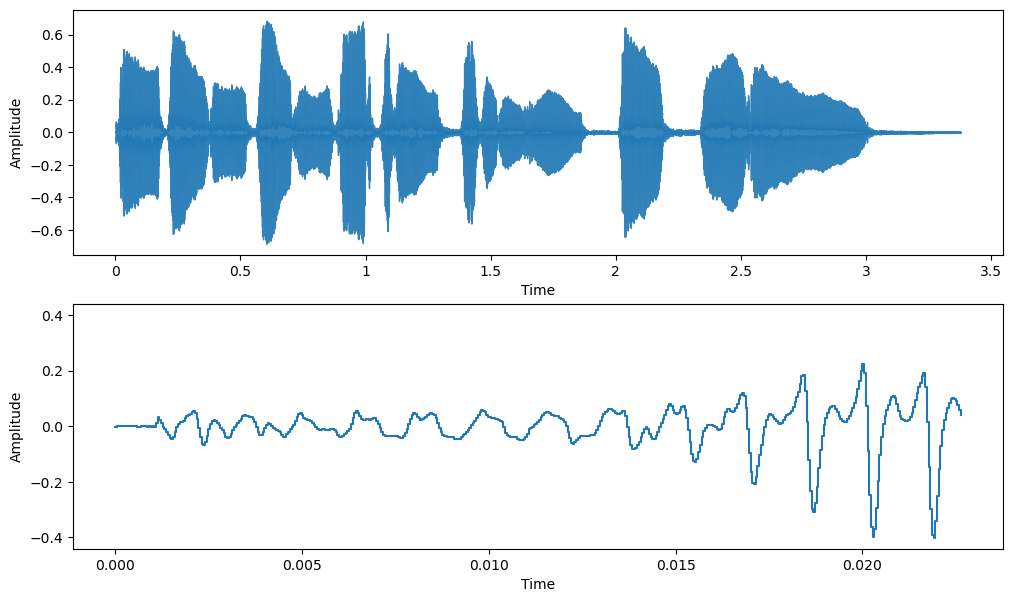

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))
ax[0].set_ylabel("Amplitude")
librosa.display.waveshow(y=y[:-43100], sr=sr, alpha=0.9, ax=ax[0])
ax[1].set_ylabel("Amplitude")
librosa.display.waveshow(y=y[:500], sr=sr, alpha=1, ax=ax[1])

Plot a spectrogram

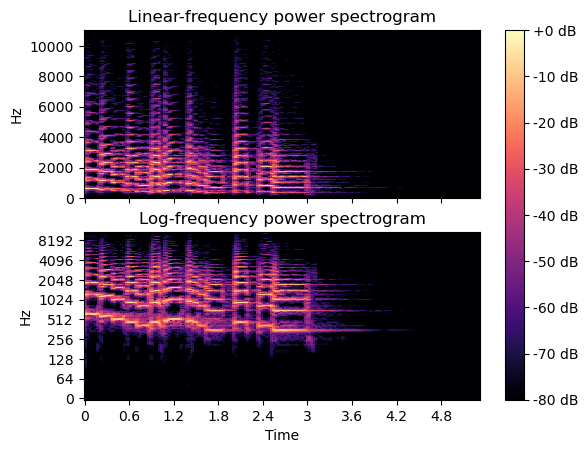

In [20]:
y, sr = librosa.load(librosa.ex('trumpet'))
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

And the Constant-Q Transform Spectrogram

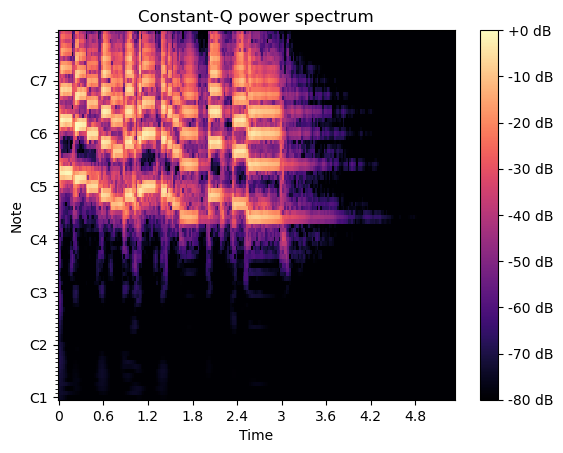

In [23]:
C = np.abs(librosa.cqt(y, sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Plot Onset Detection

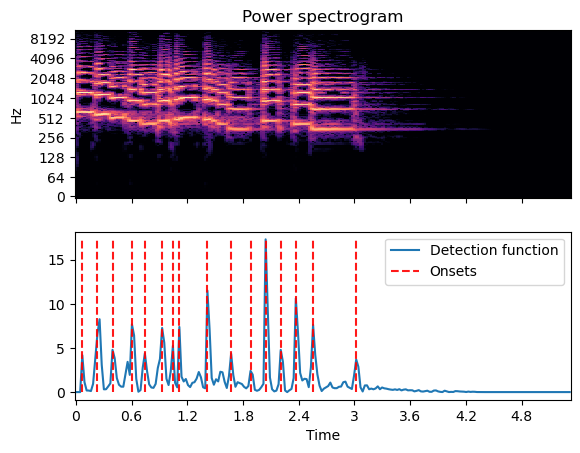

In [19]:
y, sr = librosa.load(librosa.ex('trumpet'))
o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].set_xlabel("Time")
ax[1].plot(times, o_env, label='Detection function')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()

## Plot Classification Errors and Fitness

Single Onset Experiments

In [25]:
run_number = 0
error_file = f"./experiments/ground_truth_scan/preprocess_pitch_mut_reduced_more_errors.pkl"
fitness_file = f"./experiments/ground_truth_scan/preprocess_pitch_mut_reduced_more_fitnesses.pkl"

In [26]:
with open(error_file, "rb") as fp:
    errors = pickle.load(fp)
with open(fitness_file, "rb") as fp:
    fitnesses = pickle.load(fp) 

# Parse errors into types
errors_padded = []
max_len = max([len(run) for run in errors])
for run in errors:
    while len(run) < max_len:
        run.append((0, 0, 0))
    errors_padded.append(run)
j_i_runs = [[tup[0] for tup in run] for run in errors_padded]
j_p_runs = [[tup[1] for tup in run] for run in errors_padded]
j_ip_runs = [[tup[2] for tup in run] for run in errors_padded]
j_i_means = np.mean(j_i_runs, axis=0)
j_p_means = np.mean(j_p_runs, axis=0)
j_ip_means = np.mean(j_ip_runs, axis=0)
j_i_means.shape

(10000,)

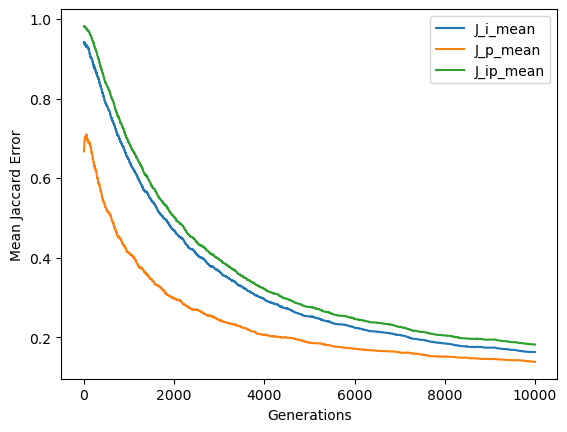

In [21]:
plt.plot(j_i_means, label="J_i_mean")
plt.plot(j_p_means, label="J_p_mean")
plt.plot(j_ip_means, label="J_ip_mean")
plt.xlabel("Generations")
plt.ylabel("Mean Jaccard Error")
plt.legend()

Text(0.5, 0.98, 'Parameters: $\\alpha=3$, $\\beta=3$, $u_{bound}=6$')

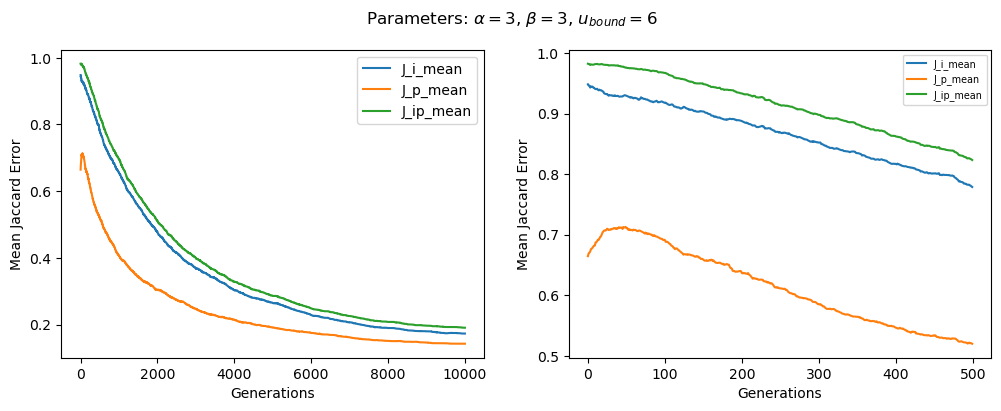

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(j_i_means, label="J_i_mean")
ax[0].plot(j_p_means, label="J_p_mean")
ax[0].plot(j_ip_means, label="J_ip_mean")
ax[0].set_xlabel("Generations")
ax[0].set_ylabel("Mean Jaccard Error")
ax[0].legend()
ax[1].plot(np.arange(0, 500), j_i_means[0:500], label="J_i_mean")
ax[1].plot(np.arange(0, 500), j_p_means[0:500], label="J_p_mean")
ax[1].plot(np.arange(0, 500), j_ip_means[0:500], label="J_ip_mean")
ax[1].set_xlabel("Generations")
ax[1].set_ylabel("Mean Jaccard Error")
ax[1].legend(fontsize='x-small')
fig.suptitle(r"Parameters: $\alpha=3$, $\beta=3$, $u_{bound}=6$")

Multi-Onsets Experiments (Full Piece)

<Axes: xlabel='Generations', ylabel='Mean Jaccard Error'>

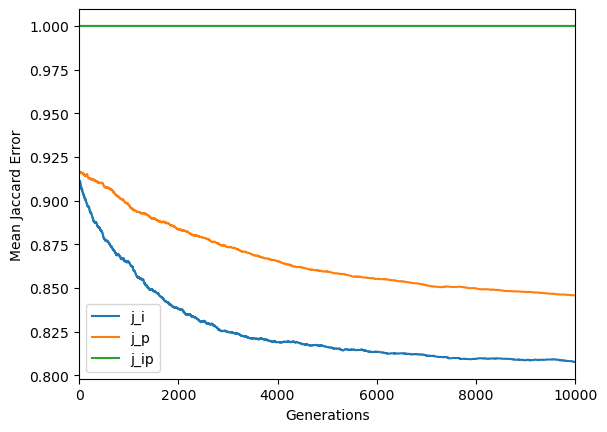

In [17]:
experiment_name = "tiny_aam/300_1_10000_0.05_5_10_1_20_0.9954_15_10_1sec_convlog"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df = pd.DataFrame({"j_i":list(j_i.mean(axis=1)), "j_p":list(j_p.mean(axis=1)), "j_ip":list(j_ip.mean(axis=1))})
df_fit = fitness.mean(axis=1)
df.plot(xlabel="Generations", ylabel="Mean Jaccard Error", xlim=(0, 10000))

<Axes: xlabel='Generations', ylabel='Mean Fitness'>

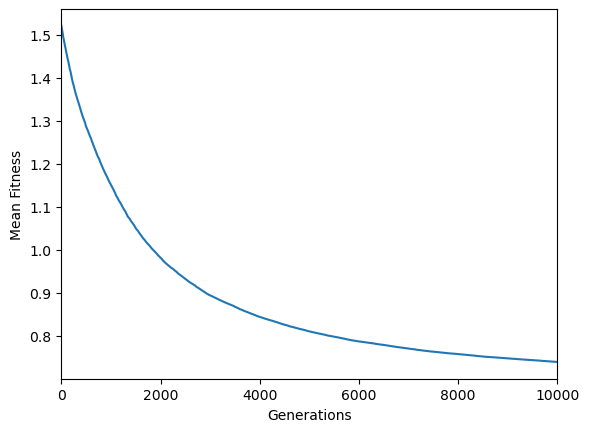

In [18]:
df_fit.plot(xlabel="Generations", ylabel="Mean Fitness", xlim=(0, 10000))

### Plotting extracted pitch probabilities

In [4]:
import librosa
from evoaudio.individual import BaseIndividual
from evoaudio.sample_library import SampleLibrary
from evoaudio.pitch import Pitch

In [5]:
lib = SampleLibrary()

Loading samples: 100%|██████████| 6826/6826 [00:13<00:00, 503.83it/s]


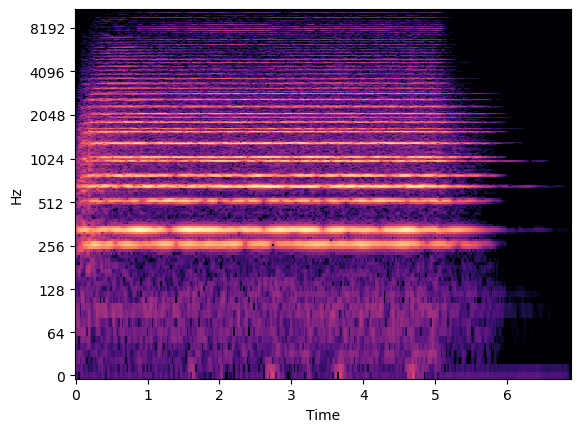

In [20]:
sr = 22050
targets = [("Trumpet", Pitch.c4), ("Trombone", Pitch.e4)]
ind = BaseIndividual()
ind.samples = [lib.get_sample(instrument=tup[0], pitch=tup[1]) for tup in targets]
mix = ind.to_mixdown()
D = librosa.amplitude_to_db(np.abs(librosa.stft(mix)), ref=np.max)
img = librosa.display.specshow(D, y_axis='log', x_axis='time',
                               sr=sr)

C:\Users\justi\AppData\Local\Temp\ipykernel_10684\3825791389.py:5: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note',


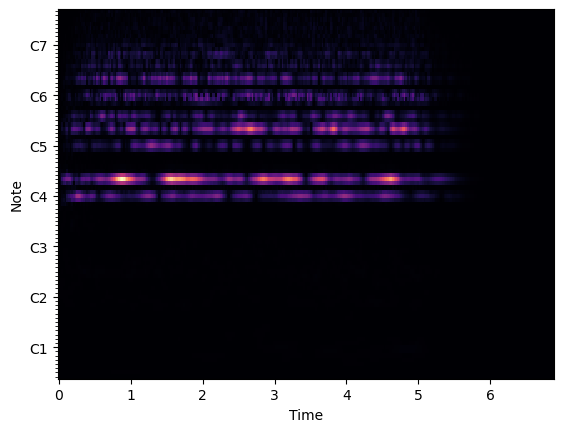

In [21]:
bins_per_octave = 12
fmin = librosa.note_to_hz("f0")
cqt = librosa.cqt(mix, sr=sr, n_bins=88, bins_per_octave=bins_per_octave, fmin=fmin)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))
librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave, fmin=fmin)

In [33]:
np.max(np.abs(cqt))

2.162541

<BarContainer object of 89 artists>

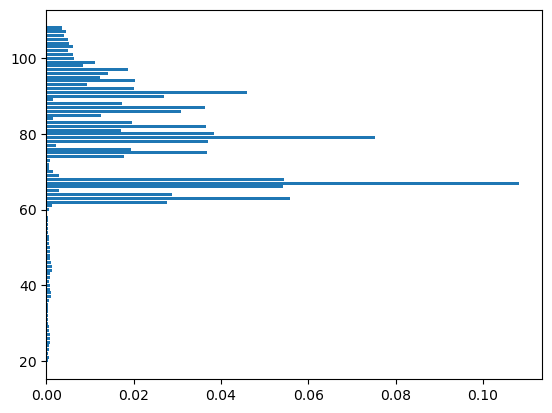

In [36]:
def extract_pitch_probabilities(y, sr=22050, n_bins=89, bins_per_octave=12, fmin=librosa.note_to_hz("f0")):
    """Estimates the pitches in the given signal y and turns
    these estimations into a probability distribution.

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    sr : int, optional
        Sample rate, by default 22050
    n_bins : int, optional
        Number of bins to return, 
        Passed to librosa.cqt, by default 89
    bins_per_octave : int, optional
        Passed to librosa.cqt, by default 12
    fmin : float, optional
        Minimum frequency for librosa.cqt, by default librosa.note_to_hz("f0")

    Returns
    -------
    np.ndarray
        A probability distribution across the 89 pitches we are working with.
    """
    cqt = librosa.cqt(y=y, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave, fmin=fmin)
    #log_cqt = librosa.amplitude_to_db(np.abs(cqt))
    abs_cqt = np.abs(cqt)
    clipped_cqt = np.clip(abs_cqt, a_min=0, a_max=None)
    # clipped_cqt[clipped_cqt < 0.5] = 0
    cqt_sum = np.sum(clipped_cqt, axis=1)
    sum_norm = cqt_sum / np.sum(cqt_sum)
    return np.nan_to_num(sum_norm)

pitches = extract_pitch_probabilities(y=mix)
plt.barh(np.arange(20, 20 + len(pitches)), pitches, )

## Plot Chord Approximation results

,j_i_mean,j_i_std,j_i_median,j_i_min,j_i_max,j_p_mean,j_p_std,j_p_median,j_p_min,j_p_max,j_ip_mean,j_ip_std,j_ip_median,j_ip_min,j_ip_max
1,0.176015,0.293270,0.160000,0.0,0.442262,0.147427,0.264534,0.140833,0.0,0.433333,0.194282,0.313627,0.181905,0.0,0.463333
2,0.187932,0.299387,0.185417,0.0,0.428095,0.151307,0.262067,0.133333,0.0,0.421667,0.205248,0.319928,0.210714,0.0,0.480000
3,0.184580,0.304887,0.170714,0.0,0.487143,0.152855,0.269235,0.130238,0.0,0.465714,0.204410,0.325862,0.197262,0.0,0.493095
4,0.264295,0.314613,0.253810,0.0,0.517857,0.175377,0.264779,0.166667,0.0,0.435714,0.289293,0.334017,0.271190,0.0,0.544643


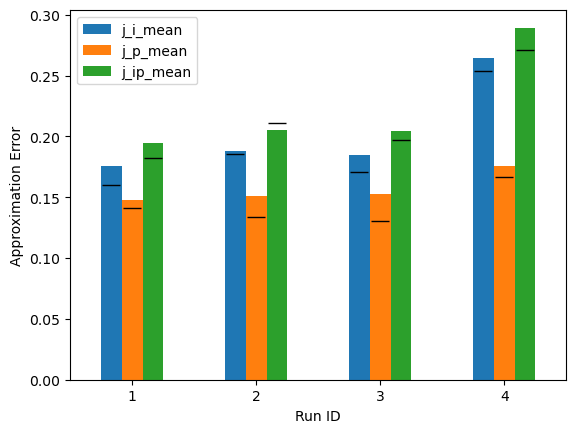

In [25]:
df = pd.read_csv("./experiments/ground_truth_scan.csv")
df = df.drop([0, 5, 6, 7])
df = df.drop(df.columns[:11], axis=1)
df = df.rename(columns={"j_i": "j_i_mean", "j_p": "j_p_mean", "j_ip": "j_ip_mean"})
fig, ax = plt.subplots()
df.plot.bar(y=["j_i_mean", "j_p_mean", "j_ip_mean"], ylabel="Approximation Error", xlabel="Run ID", ax=ax, rot=0)
plt.plot(np.arange(len(list(df['j_i_mean'])))-0.17, list(df['j_i_median']), "k_", markersize=13)
plt.plot(np.arange(len(list(df['j_p_mean']))), list(df['j_p_median']), "k_", markersize=13)
plt.plot(np.arange(len(list(df['j_ip_mean'])))+0.17, list(df['j_ip_median']), "k_", markersize=13)
plt.legend()
df

In [16]:
df_full = pd.read_csv("./experiments/pitch_approximation_results_uniform_styles.csv")
df_print = df_full.drop(list(range(3)))
df_print = df_print.drop(list(range(4,9)))
df_print = df_print.drop(df_print.columns[:6], axis=1)
df_print = df_print.drop(["N_RUNS", "j_i", "j_i_std", "j_p_std", "j_ip_std"], axis=1)
with open("./table.tex", "w") as fp:
    df_print.to_latex(buf=fp, index=False)

C:\Users\justi\AppData\Local\Temp\ipykernel_8900\4255890701.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_print.to_latex(buf=fp, index=False)


In [15]:
df_print

,U_BOUND,ZETA,PITCH_SHIFT_STD,j_p,j_ip
3,20,0.9954,6,0.179538,0.333215
9,10,1.0000,15,0.302010,0.430816
10,10,0.9954,15,0.145656,0.336743


## Plot Shifted-Pitch Ground Truth Search Results

In [19]:
df = pd.read_csv("./experiments/fixed_shifted_pitch.csv")
df = df.drop(df.columns[:10], axis=1)
df = df[["PITCH_OFFSET", "j_i", "j_p", "j_ip"]]
df = df.round(3)
df = df.transpose()
with open("./table.tex", "w") as fp:
    df.to_latex(buf=fp, index=True)

C:\Users\justi\AppData\Local\Temp\ipykernel_20360\2027618453.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(buf=fp, index=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12
PITCH_OFFSET,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000
j_i,0.016,0.860,0.865,0.879,0.883,0.885,0.899,0.892,0.899,0.907,0.908,0.920,0.893
j_p,0.000,0.973,0.977,0.978,0.977,0.980,0.982,0.977,0.981,0.980,0.976,0.982,0.982
j_ip,0.017,0.989,0.990,0.990,0.992,0.992,0.992,0.990,0.992,0.993,0.991,0.992,0.992


## Statistics about The Sample Library

In [20]:
from evoaudio.sample_library import SampleLibrary
lib = SampleLibrary()

Loading samples: 100%|██████████| 6826/6826 [00:11<00:00, 594.74it/s]


In [26]:
from evoaudio.pitch import Pitch
df = pd.DataFrame(columns=["Instrument Name", "Number of Styles", "Minimum Pitch", "Maximum Pitch"])
style_counts = dict()
min_pitches = dict()
max_pitches = dict()
for instrument in lib.instruments:
    instr_info = lib.instruments[instrument]
    df.loc[len(df.index)] = {
        "Instrument Name": instrument, 
        "Number of Styles": len(instr_info.styles), 
        "Minimum Pitch": Pitch(min(list(instr_info.min_pitches.values()))).name, 
        "Maximum Pitch": Pitch(max(list(instr_info.max_pitches.values()))).name}
with open("./table.tex", "w") as fp:
    df.to_latex(buf=fp, index=False)

C:\Users\justi\AppData\Local\Temp\ipykernel_20360\751086670.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(buf=fp, index=False)


In [28]:
from evoaudio.pitch import DrumHit
df = pd.DataFrame(columns=["MIDI Integer", "Pitch", "Drum Hit"])
for i in range(20, 109):
    pitch = Pitch(i).name
    hit = ""
    if i >= 36 and i <= 64:
        hit = DrumHit(i).name
    df.loc[len(df.index)] = { "MIDI Integer": i, "Pitch": pitch, "Drum Hit": hit }
with open("./table.tex", "w") as fp:
    df.to_latex(buf=fp, index=False)

C:\Users\justi\AppData\Local\Temp\ipykernel_20360\652374865.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(buf=fp, index=False)
